In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)

# print(os.getcwd())

In [2]:
## Read raw data
df = pd.read_csv("data/full_dataframe_1node_2hrs_23dims.csv").drop('timestamp', 1)

## Remove redundant prefix name
prefix = "192.168.13.108.443-"
df.columns = [c.replace(prefix, "") for c in df.columns]

## Min-Max normalization
for c in df.columns:
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape((df[c].shape[0], -1)))

### Center points
## Read center of clusters
centers_df = pd.read_csv("data/data_cluster.csv")
feature_cols = sorted(list(set(centers_df.columns).intersection(set(df.columns))))

## get feature cols only
centers_df = centers_df[feature_cols]

## MinMax norm
for c in feature_cols:
    centers_df[c] = MinMaxScaler().fit_transform(centers_df[c].values.reshape((centers_df[c].shape[0], -1)))

## num of clusters   
len_cluster = centers_df.shape[0]

## convert pandas to list
center_list = [centers_df.iloc[i].values for i in range(len_cluster)]



## get feature cols only
df = df[feature_cols]

my_labels = pd.read_csv("data/pred.csv")

df_full = pd.concat([df, my_labels],1)

df_full.head()

,CPU1TempTemperatureReading-TemperatureReading,CPU2TempTemperatureReading-TemperatureReading,CUPSSystemUsage-CPUUsage,CUPSSystemUsage-IOUsage,CUPSSystemUsage-MemoryUsage,CUPSSystemUsage-SystemUsage,DIMMSocketA1TemperatureReading-TemperatureReading,DIMMSocketA2TemperatureReading-TemperatureReading,DIMMSocketA3TemperatureReading-TemperatureReading,DIMMSocketA4TemperatureReading-TemperatureReading,DIMMSocketA5TemperatureReading-TemperatureReading,DIMMSocketA6TemperatureReading-TemperatureReading,Fan1RPMReading-RPMReading,Fan2RPMReading-RPMReading,Fan3RPMReading-RPMReading,Fan4RPMReading-RPMReading,Fan5RPMReading-RPMReading,Fan6RPMReading-RPMReading,PowerMetricsTotalStoragePower-SystemPowerConsumption,PowerMetricsTotalStoragePower-TotalCPUPower,PowerMetricsTotalStoragePower-TotalMemoryPower,ThermalTotalPSUHeatDissipation-PowerToCoolRatio,ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower,cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034091,0.231156,0.6,1.0,1.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034091,0.231156,0.6,1.0,1.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034091,0.231156,0.6,1.0,1.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034091,0.231156,0.6,1.0,1.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034091,0.231156,0.6,1.0,1.0,0


In [3]:
df_full.columns

cols = ['DIMMSocketA5TemperatureReading-TemperatureReading', 'DIMMSocketA6TemperatureReading-TemperatureReading','CUPSSystemUsage-IOUsage','Fan1RPMReading-RPMReading', 'Fan3RPMReading-RPMReading']

for c in df_full.columns:
    print(df_full[c].value_counts())
    if c in cols:
        print("!!!!!!!!!!")
    print("\n")

0.000000    1176
0.925926    1030
0.851852     517
0.074074     517
0.592593     516
1.000000     494
0.185185     493
0.037037     285
Name: CPU1TempTemperatureReading-TemperatureReading, dtype: int64


0.000000    1176
0.923077    1011
0.961538     518
0.076923     517
0.884615     516
1.000000     512
0.192308     493
0.038462     285
Name: CPU2TempTemperatureReading-TemperatureReading, dtype: int64


1.000000    2043
0.010417    1660
0.000000    1266
0.989583      59
Name: CUPSSystemUsage-CPUUsage, dtype: int64


0.0    5028
Name: CUPSSystemUsage-IOUsage, dtype: int64
!!!!!!!!!!


0.0000    2926
1.0000    1067
0.9375    1035
Name: CUPSSystemUsage-MemoryUsage, dtype: int64


0.000000    2212
1.000000    1035
0.988095    1008
0.011905     714
0.976190      59
Name: CUPSSystemUsage-SystemUsage, dtype: int64


1.0    4538
0.0     490
Name: DIMMSocketA1TemperatureReading-TemperatureReading, dtype: int64


1.0    2633
0.0    2395
Name: DIMMSocketA2TemperatureReading-TemperatureReading, d

In [4]:
import numpy as np

Index(['CPU1TempTemperatureReading-TemperatureReading', 'CPU2TempTemperatureReading-TemperatureReading', 'CUPSSystemUsage-CPUUsage', 'CUPSSystemUsage-IOUsage', 'CUPSSystemUsage-MemoryUsage', 'CUPSSystemUsage-SystemUsage', 'DIMMSocketA1TemperatureReading-TemperatureReading', 'DIMMSocketA2TemperatureReading-TemperatureReading', 'DIMMSocketA3TemperatureReading-TemperatureReading', 'DIMMSocketA4TemperatureReading-TemperatureReading', 'DIMMSocketA5TemperatureReading-TemperatureReading', 'DIMMSocketA6TemperatureReading-TemperatureReading', 'Fan1RPMReading-RPMReading', 'Fan2RPMReading-RPMReading', 'Fan3RPMReading-RPMReading', 'Fan4RPMReading-RPMReading', 'Fan5RPMReading-RPMReading', 'Fan6RPMReading-RPMReading', 'PowerMetricsTotalStoragePower-SystemPowerConsumption', 'PowerMetricsTotalStoragePower-TotalCPUPower', 'PowerMetricsTotalStoragePower-TotalMemoryPower', 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio', 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower', 'cluster'], dtype='ob

In [29]:

std_dict = dict()
for c in df_full.drop("cluster",1).columns[1:]:
    std_dict[c] = df_full[c].std()
std_dict = sorted( std_dict.items(), key=lambda x: x[1], reverse=True)
std_dict

[('DIMMSocketA2TemperatureReading-TemperatureReading', 0.4994892103485316),
 ('CUPSSystemUsage-CPUUsage', 0.4902466852345531),
 ('CUPSSystemUsage-SystemUsage', 0.488744285414679),
 ('CUPSSystemUsage-MemoryUsage', 0.47853515367895944),
 ('PowerMetricsTotalStoragePower-SystemPowerConsumption', 0.4780023892354582),
 ('DIMMSocketA4TemperatureReading-TemperatureReading', 0.4695181081516693),
 ('CPU2TempTemperatureReading-TemperatureReading', 0.44363347477806875),
 ('ThermalTotalPSUHeatDissipation-PowerToCoolRatio', 0.43278432359112884),
 ('ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower',
  0.4299588695383446),
 ('Fan4RPMReading-RPMReading', 0.40258971114051545),
 ('Fan5RPMReading-RPMReading', 0.37549727084216883),
 ('PowerMetricsTotalStoragePower-TotalCPUPower', 0.3556829594383757),
 ('Fan6RPMReading-RPMReading', 0.3467471179748571),
 ('Fan2RPMReading-RPMReading', 0.31578510008620664),
 ('PowerMetricsTotalStoragePower-TotalMemoryPower', 0.3130090464372037),
 ('DIMMSocketA1TemperatureReading-TemperatureReading', 0.29660482299224084),
 ('DIMMSocketA3TemperatureReading-TemperatureReading', 0.29660482299224084),
 ('CUPSSystemUsage-IOUsage', 0.0),
 ('DIMMSocketA5TemperatureReading-TemperatureReading', 0.0),
 ('DIMMSocketA6TemperatureReading-TemperatureReading', 0.0),
 ('Fan1RPMReading-RPMReading', 0.0),
 ('Fan3RPMReading-RPMReading', 0.0)]

In [30]:
import plotly.express as px
features_= [x[0] for x in std_dict]
values_= [x[1] for x in std_dict]

data_canada = pd.DataFrame({"feature_name": features_, "importance_value": values_})
fig = px.bar(data_canada, x='feature_name', y='importance_value')
fig.show()

In [7]:
df_full["cluster"].value_counts()

0    1698
6    1278
5     441
8     409
4     383
1     340
3     208
7     195
2      76
Name: cluster, dtype: int64

In [8]:
feature_cols

['CPU1TempTemperatureReading-TemperatureReading',
 'CPU2TempTemperatureReading-TemperatureReading',
 'CUPSSystemUsage-CPUUsage',
 'CUPSSystemUsage-IOUsage',
 'CUPSSystemUsage-MemoryUsage',
 'CUPSSystemUsage-SystemUsage',
 'DIMMSocketA1TemperatureReading-TemperatureReading',
 'DIMMSocketA2TemperatureReading-TemperatureReading',
 'DIMMSocketA3TemperatureReading-TemperatureReading',
 'DIMMSocketA4TemperatureReading-TemperatureReading',
 'DIMMSocketA5TemperatureReading-TemperatureReading',
 'DIMMSocketA6TemperatureReading-TemperatureReading',
 'Fan1RPMReading-RPMReading',
 'Fan2RPMReading-RPMReading',
 'Fan3RPMReading-RPMReading',
 'Fan4RPMReading-RPMReading',
 'Fan5RPMReading-RPMReading',
 'Fan6RPMReading-RPMReading',
 'PowerMetricsTotalStoragePower-SystemPowerConsumption',
 'PowerMetricsTotalStoragePower-TotalCPUPower',
 'PowerMetricsTotalStoragePower-TotalMemoryPower',
 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio',
 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower']

In [9]:
df_full.shape

(5028, 24)

In [10]:
df_full.iloc[0]

CPU1TempTemperatureReading-TemperatureReading                0.000000
CPU2TempTemperatureReading-TemperatureReading                0.000000
CUPSSystemUsage-CPUUsage                                     0.000000
CUPSSystemUsage-IOUsage                                      0.000000
CUPSSystemUsage-MemoryUsage                                  0.000000
CUPSSystemUsage-SystemUsage                                  0.000000
DIMMSocketA1TemperatureReading-TemperatureReading            1.000000
DIMMSocketA2TemperatureReading-TemperatureReading            0.000000
DIMMSocketA3TemperatureReading-TemperatureReading            1.000000
DIMMSocketA4TemperatureReading-TemperatureReading            0.000000
DIMMSocketA5TemperatureReading-TemperatureReading            0.000000
DIMMSocketA6TemperatureReading-TemperatureReading            0.000000
Fan1RPMReading-RPMReading                                    0.000000
Fan2RPMReading-RPMReading                                    0.000000
Fan3RPMReading-RPMRe

## TRAIN

num feature_cols = 23 
Training until validation scores don't improve for 200 rounds
[100]	train's multi_logloss: 0.880343	valid's multi_logloss: 0.879511
[200]	train's multi_logloss: 0.505983	valid's multi_logloss: 0.505066
[300]	train's multi_logloss: 0.301538	valid's multi_logloss: 0.300773
[400]	train's multi_logloss: 0.182692	valid's multi_logloss: 0.182088
[500]	train's multi_logloss: 0.111717	valid's multi_logloss: 0.111277
[600]	train's multi_logloss: 0.0686441	valid's multi_logloss: 0.0682953
[700]	train's multi_logloss: 0.0423812	valid's multi_logloss: 0.0421257
[800]	train's multi_logloss: 0.0261727	valid's multi_logloss: 0.0259841
[900]	train's multi_logloss: 0.0162384	valid's multi_logloss: 0.0161058
[1000]	train's multi_logloss: 0.0100965	valid's multi_logloss: 0.0100039
[1100]	train's multi_logloss: 0.00629508	valid's multi_logloss: 0.00623095
[1200]	train's multi_logloss: 0.00393549	valid's multi_logloss: 0.00389266
[1300]	train's multi_logloss: 0.00246286	valid's multi

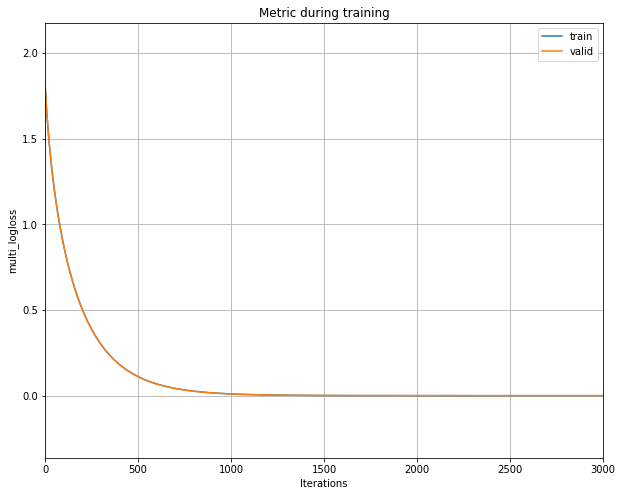

In [11]:
n_jobs = 16
feature_cols = feature_cols
cate_cols = list()
early_stopping = 200

using_SMOTE = False

feature_cols = feature_cols
cate_cols = list()

X_train, X_valid, y_train, y_valid = train_test_split(df_full[feature_cols], df_full["cluster"], test_size=0.33, random_state=2020, stratify = df_full["cluster"])


####################
## RUN THE MODEL ##
###################

## NO need to edit this cell ##

start_time = datetime.now()

random_seed = 2020

print("num feature_cols = {} ".format(len(feature_cols)))

## prepare the model
lgb_params = {
    'boosting_type':'gbdt', 'colsample_bytree':0.5, #'class_weight': {0 : 1. , 1: weight},
    'importance_type':'gain', 'learning_rate':0.005, 'max_depth':3,
    'min_child_samples':20,# 'min_child_weight':0.001, 'min_split_gain':0.0,
    'n_estimators':3000, 'n_jobs': n_jobs, 'num_leaves':31, 'subsample_freq':16,
    'seed': random_seed, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
    'subsample':0.5, 'subsample_for_bin':200000,  "metric": "multi_logloss" ,'objective':"multiclass"
}

lgb_model = lgb.LGBMClassifier(**lgb_params)


record_store = dict()
lgb_model.fit( X=X_train, y=y_train, feature_name = feature_cols, #categorical_feature = cate_cols, 
              early_stopping_rounds= early_stopping, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              eval_names=["train", "valid"],
              eval_metric= "multi_logloss",
              verbose = 100, callbacks = [lgb.record_evaluation(record_store)])

# calc loss error for valid set
y_pred = lgb_model.predict(X_valid)
y_pred_prob = lgb_model.predict_proba(X_valid)


oof = pd.concat([X_valid, y_valid], 1)
oof['pred'] = y_pred
oof['prob_0'] = y_pred_prob[:,0]
oof['prob_1'] = y_pred_prob[:,1]

# plot learning curve 
f = lgb.plot_metric(record_store, figsize=(10,8))
training_time = datetime.now() - start_time

print("done in ", training_time)

# Check the model on trainning set

In [12]:
pred_train = lgb_model.predict(X_train)
print("Accuracy on trainning set", accuracy_score(y_train, pred_train))

Accuracy on trainning set 1.0


# Check the model on trainning set

In [13]:
pred_valid = lgb_model.predict(X_valid)
print("Accuracy on valid set", accuracy_score(y_valid, pred_valid))

Accuracy on valid set 1.0


In [14]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_valid)

shap_values_np = np.array(shap_values)
shap.initjs()

# Show feature importance for each feature of each class 

In [15]:
shap_importance = pd.DataFrame({"feature_name": feature_cols})

for i in range(len_cluster):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, f"cluster_{i}": np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")

In [16]:
tmp = shap_importance.drop("feature_name", 1).sum(axis=1).sort_values(ascending=True).index
shap_importance = shap_importance.reindex(tmp)
shap_importance

,feature_name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
11,DIMMSocketA6TemperatureReading-TemperatureReading,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,CUPSSystemUsage-IOUsage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,Fan3RPMReading-RPMReading,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,Fan1RPMReading-RPMReading,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,DIMMSocketA5TemperatureReading-TemperatureReading,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20,PowerMetricsTotalStoragePower-TotalMemoryPower,168.075990,288.390165,129.316171,5.830314,0.089696,0.204927,0.700647,90.614842,602.050110
9,DIMMSocketA4TemperatureReading-TemperatureReading,2.788243,0.028400,1.429803,22.066327,1078.924268,310.342682,0.003000,3.700606,6.615918
17,Fan6RPMReading-RPMReading,0.046974,0.007135,9.679008,166.204963,156.252247,1037.327048,135.121524,0.025477,0.016633
1,CPU2TempTemperatureReading-TemperatureReading,220.560712,0.441483,43.360999,49.837651,91.467104,110.862337,37.180698,902.796028,92.626786
0,CPU1TempTemperatureReading-TemperatureReading,524.674639,2.987782,88.100533,109.640432,199.813064,174.449805,186.102882,279.099840,177.493051


In [17]:
shap_importance["feature_name"].values

array(['DIMMSocketA6TemperatureReading-TemperatureReading',
       'CUPSSystemUsage-IOUsage', 'Fan3RPMReading-RPMReading',
       'Fan1RPMReading-RPMReading',
       'DIMMSocketA5TemperatureReading-TemperatureReading',
       'PowerMetricsTotalStoragePower-TotalMemoryPower',
       'DIMMSocketA4TemperatureReading-TemperatureReading',
       'Fan6RPMReading-RPMReading',
       'CPU2TempTemperatureReading-TemperatureReading',
       'CPU1TempTemperatureReading-TemperatureReading',
       'DIMMSocketA3TemperatureReading-TemperatureReading',
       'DIMMSocketA2TemperatureReading-TemperatureReading',
       'Fan2RPMReading-RPMReading', 'CUPSSystemUsage-MemoryUsage',
       'CUPSSystemUsage-SystemUsage', 'Fan4RPMReading-RPMReading',
       'Fan5RPMReading-RPMReading', 'CUPSSystemUsage-CPUUsage',
       'DIMMSocketA1TemperatureReading-TemperatureReading',
       'PowerMetricsTotalStoragePower-SystemPowerConsumption',
       'PowerMetricsTotalStoragePower-TotalCPUPower',
       'ThermalTotalP

In [18]:
import plotly.graph_objects as go
colors =["#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#bcbd22",
    "#17becf"]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])

y = shap_importance["feature_name"]

fig = go.Figure()
for i in class_inds:
    fig.add_trace(go.Bar(y=y, x=shap_importance[f"cluster_{i}"], name=f"Group {i+1}", orientation='h', marker=dict(
        color=colors[i]
    )))


fig.update_layout(barmode='stack'
                  , title_text='Feature importance using SHAP',   
        yaxis=dict(
        title='Feature Name',
    ),   xaxis=dict(
        title='Importance Value',
    )
                 )
fig.show()

import plotly.offline as pyo
pyo.plot(fig, filename='feature_importance.html')

'feature_importance.html'

In [19]:
class_inds

array([0, 6, 8, 4, 5, 3, 1, 7, 2])

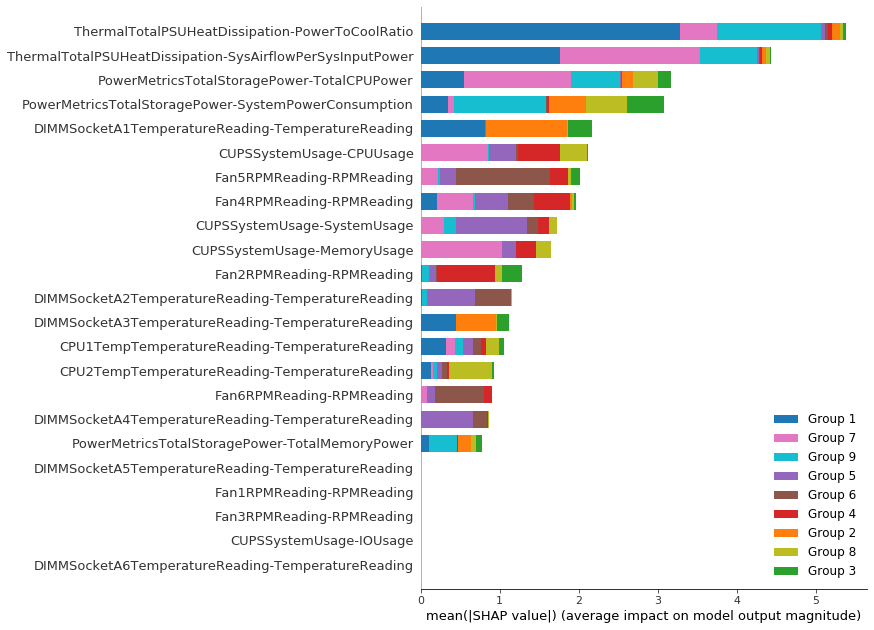

In [20]:
from matplotlib import colors as plt_colors

colors =["#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#bcbd22",
    "#17becf"]
# get class ordering from shap values
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])

# create listed colormap
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

shap.summary_plot(shap_values, X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar",color=cmap, class_names=[f"Group {i+1}" for i in range(len_cluster)])

Each feature has different contributions on each class.

Ex: Power to cool Ratio has a huge impact on class 0 (blue), whereas much smaller for class 7 (green)

cluster 0


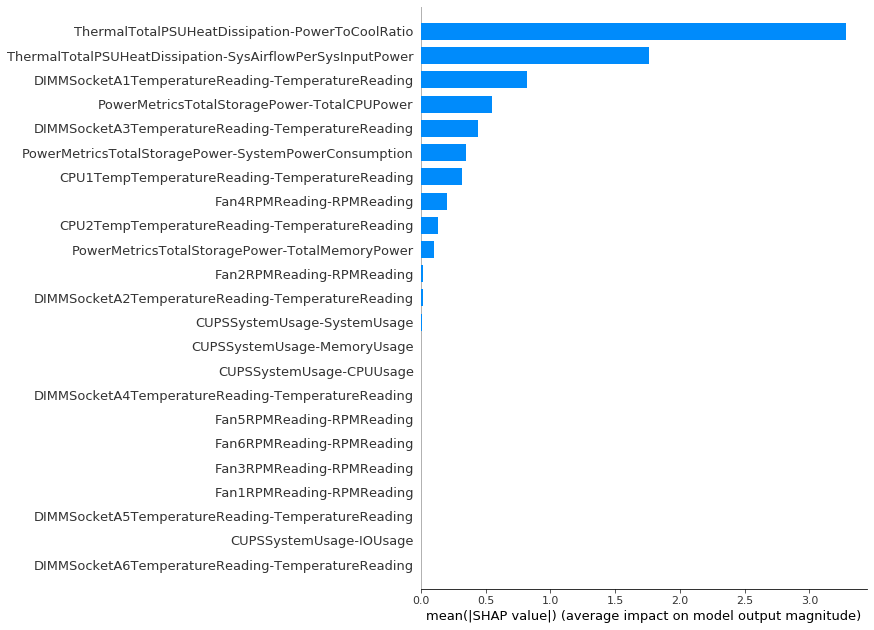



cluster 1


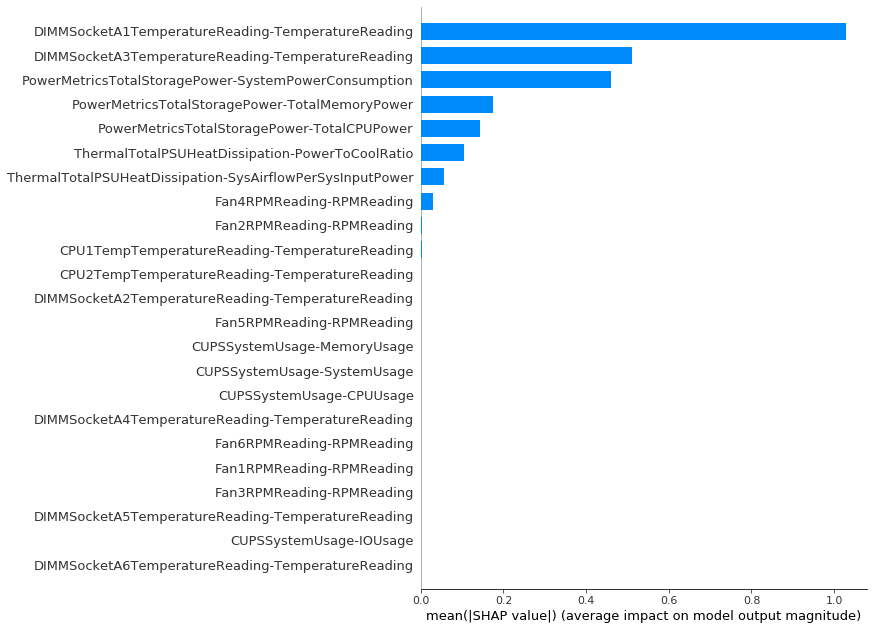



cluster 2


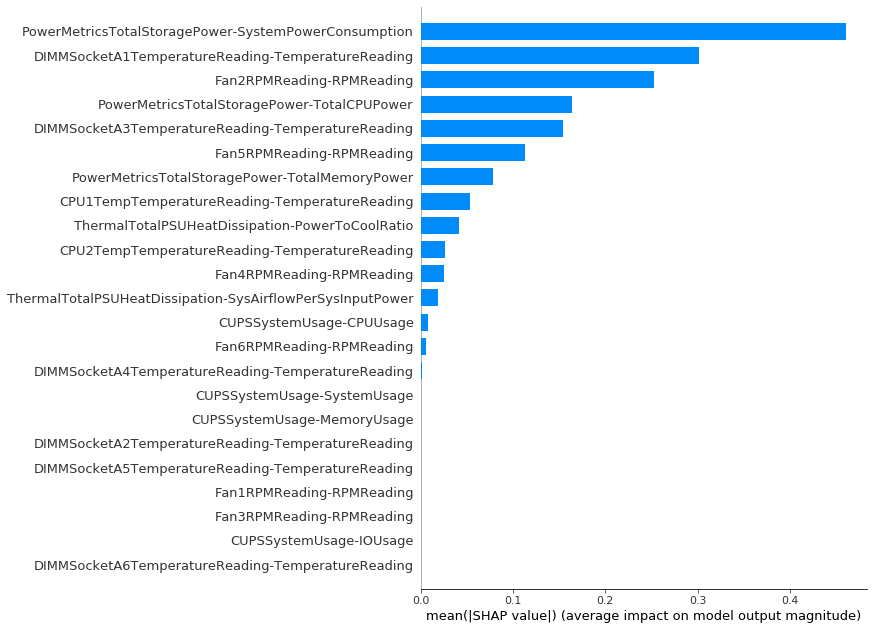



cluster 3


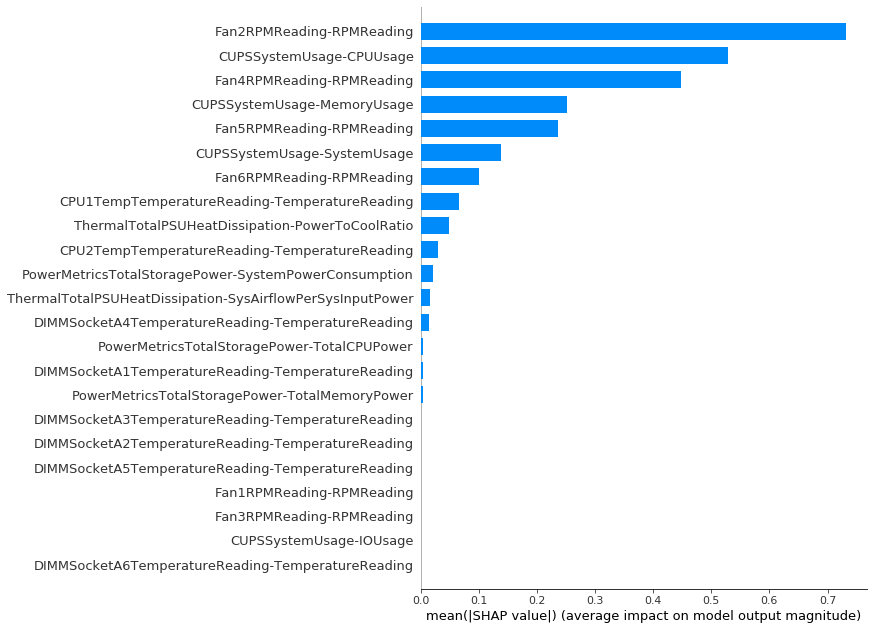



cluster 4


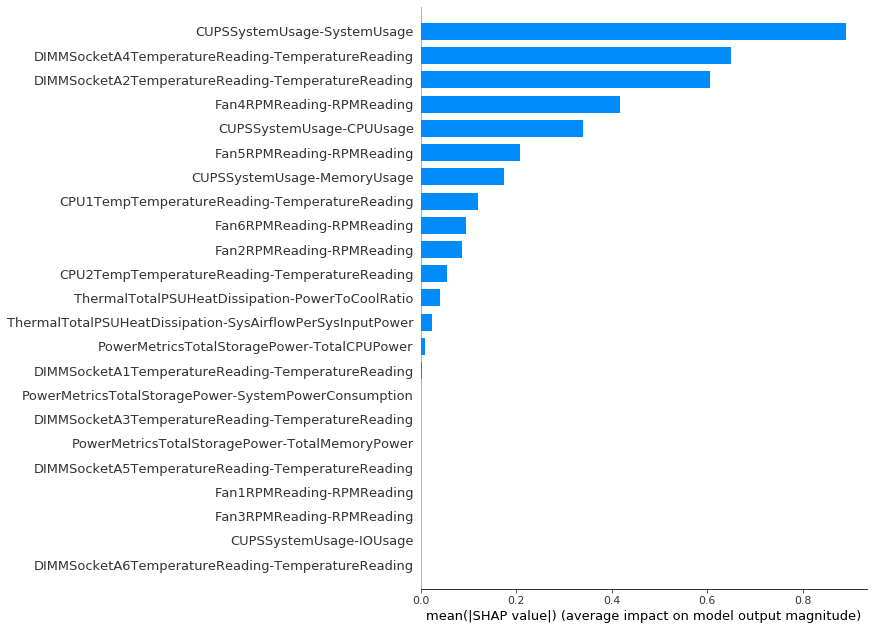



cluster 5


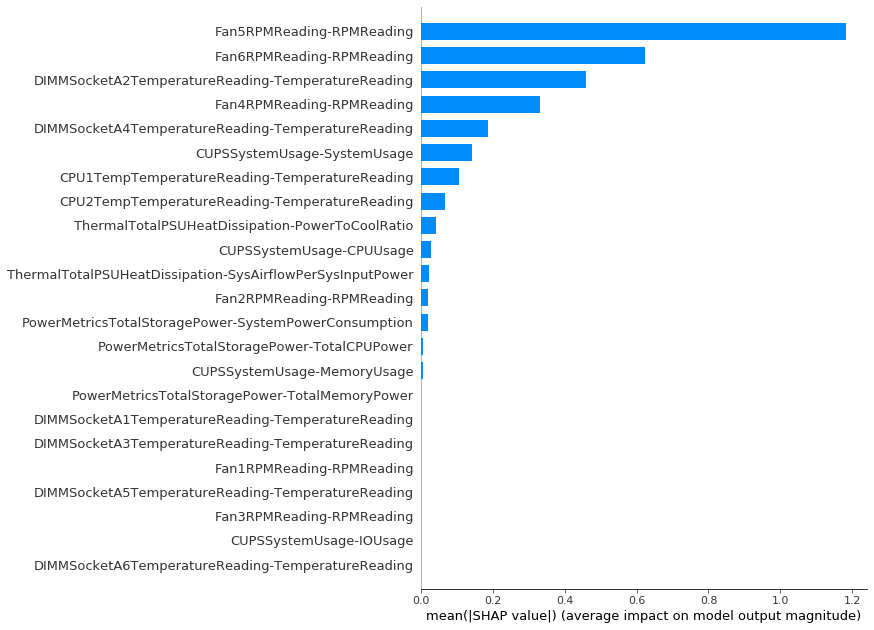



cluster 6


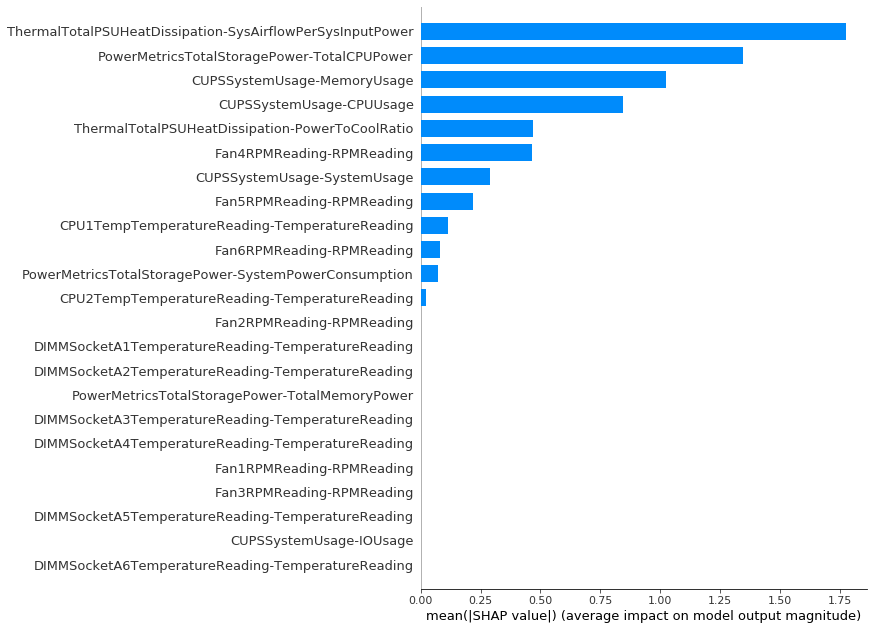



cluster 7


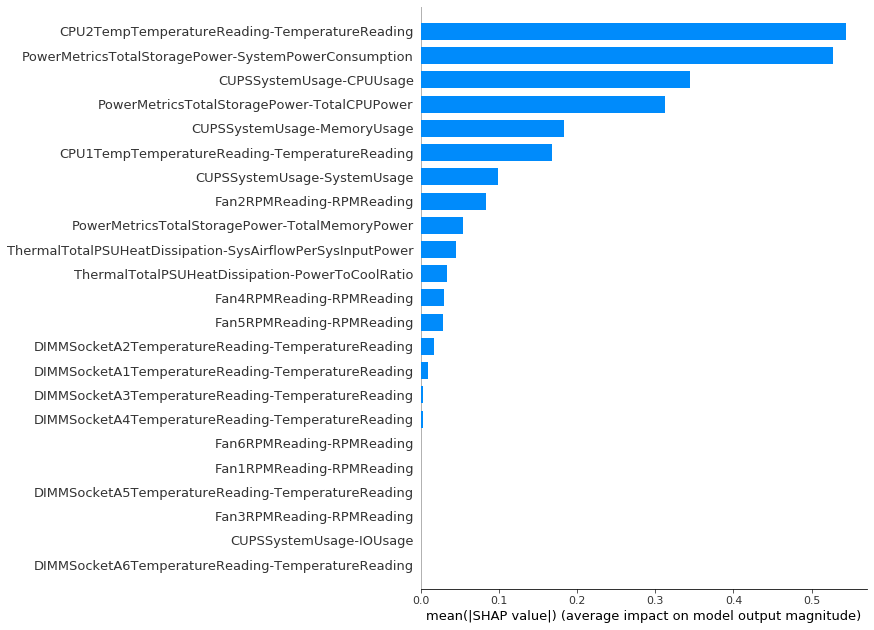



cluster 8


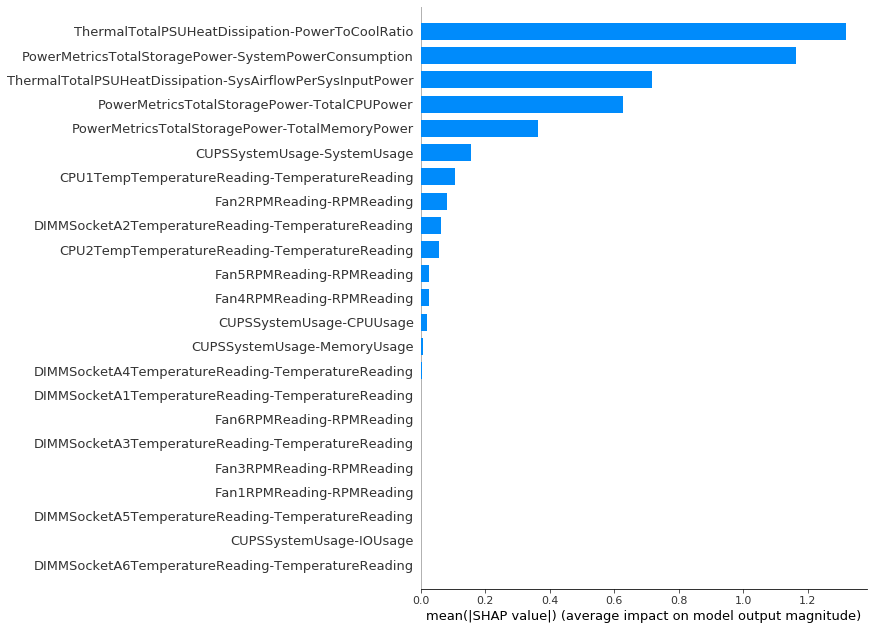

In [21]:
## Show top feature importances of each class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar")
    print("cluster", i)
    plt.show(f)
    print("\n")

# Show feature importance for each instance/observation

In [22]:
i = 0

x = list(range(len(feature_cols)))
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(shape_1obs.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[:,i], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


In [23]:
i = 0

x = feature_cols
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(len_cluster):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[i,:], name="cluster "+str(i), mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


cluster 0


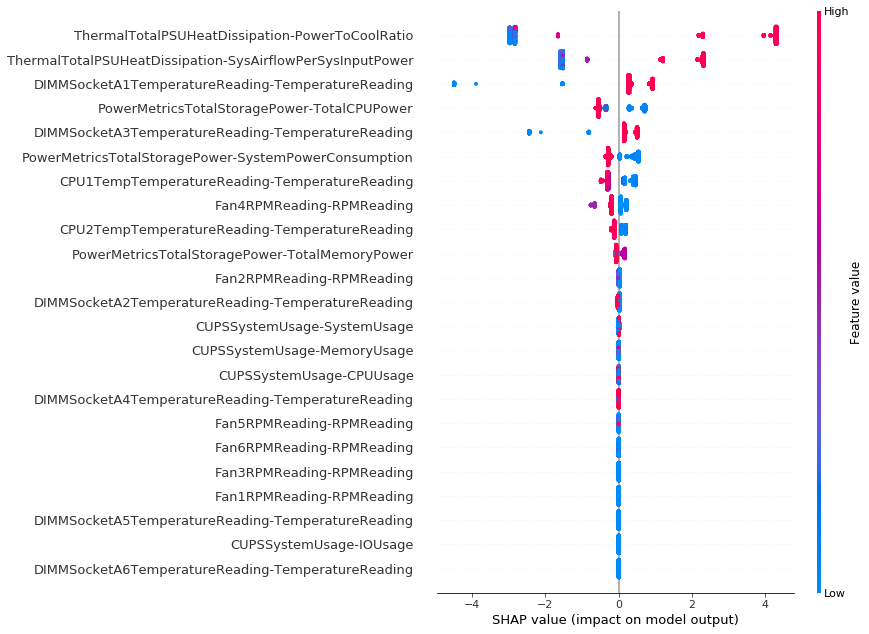



cluster 1


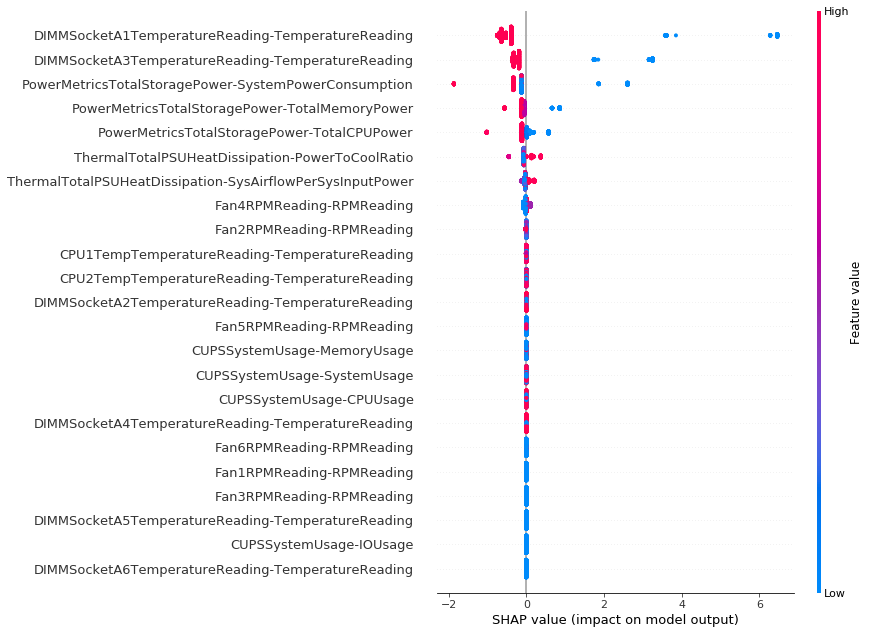



cluster 2


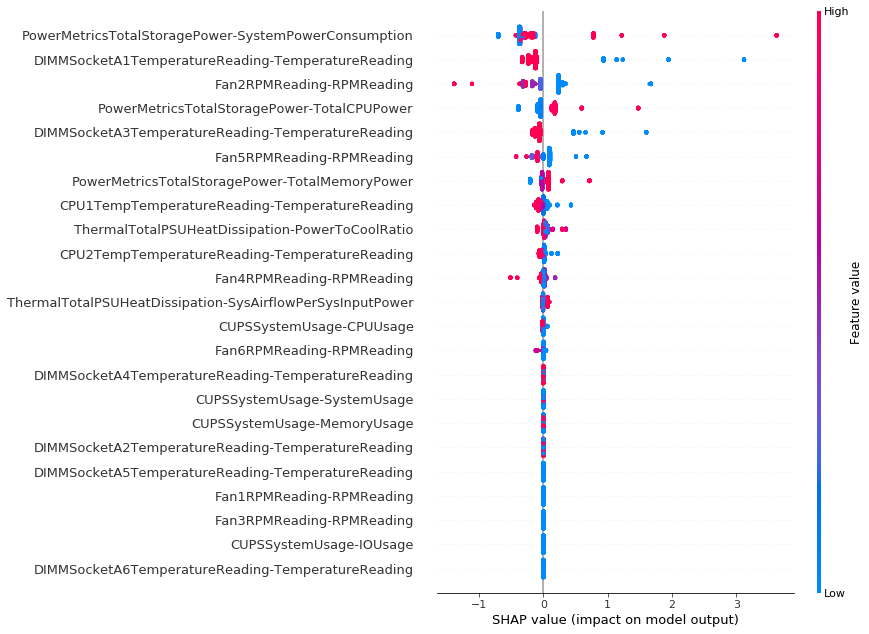



cluster 3


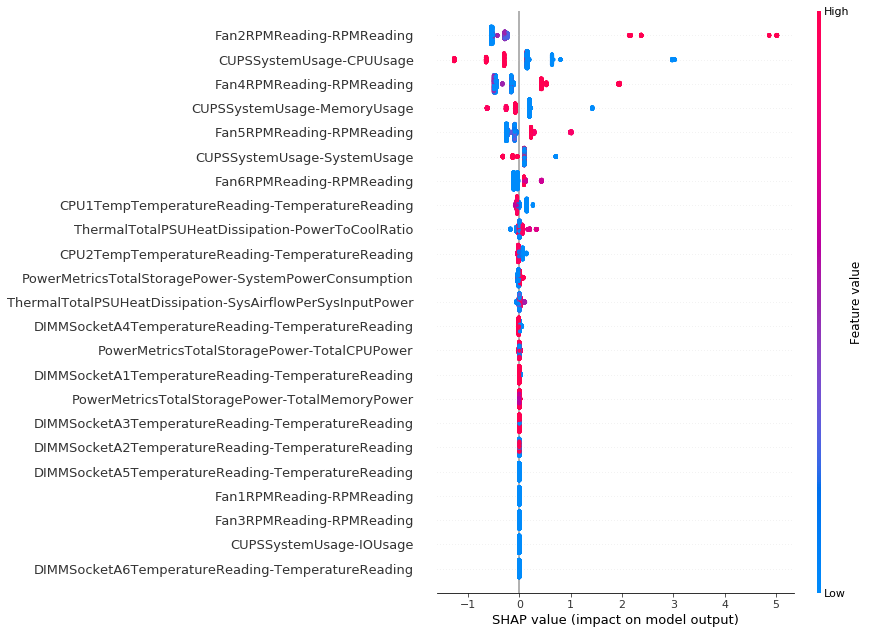



cluster 4


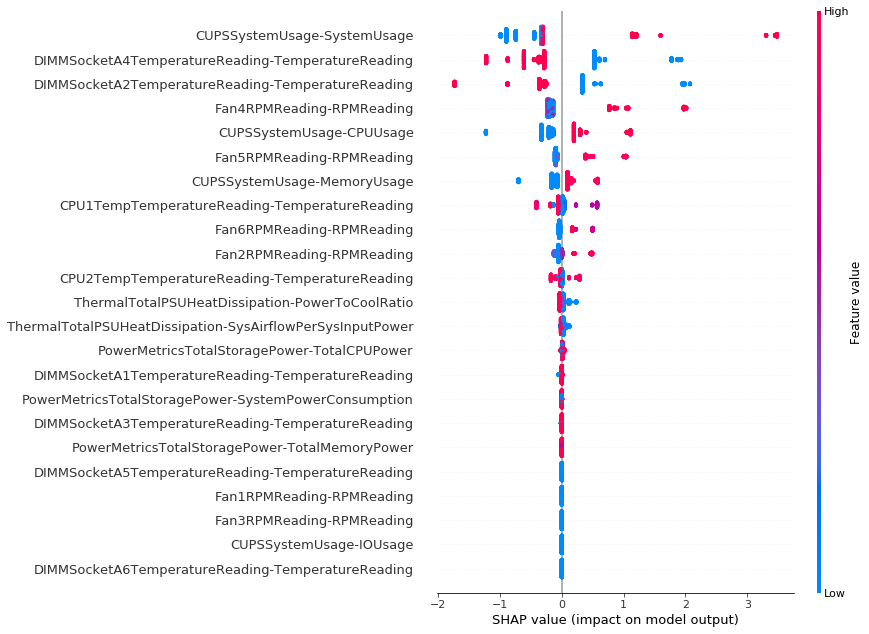



cluster 5


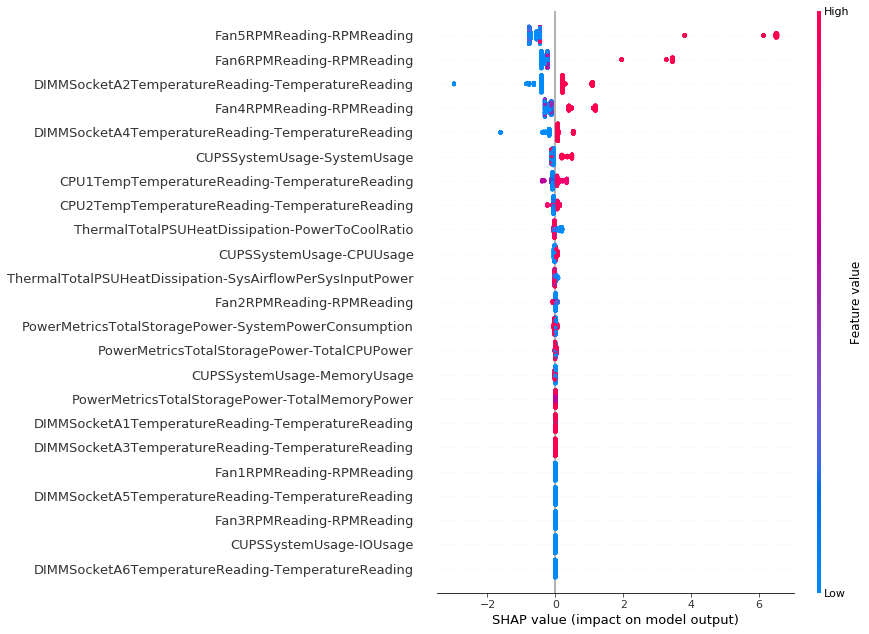



cluster 6


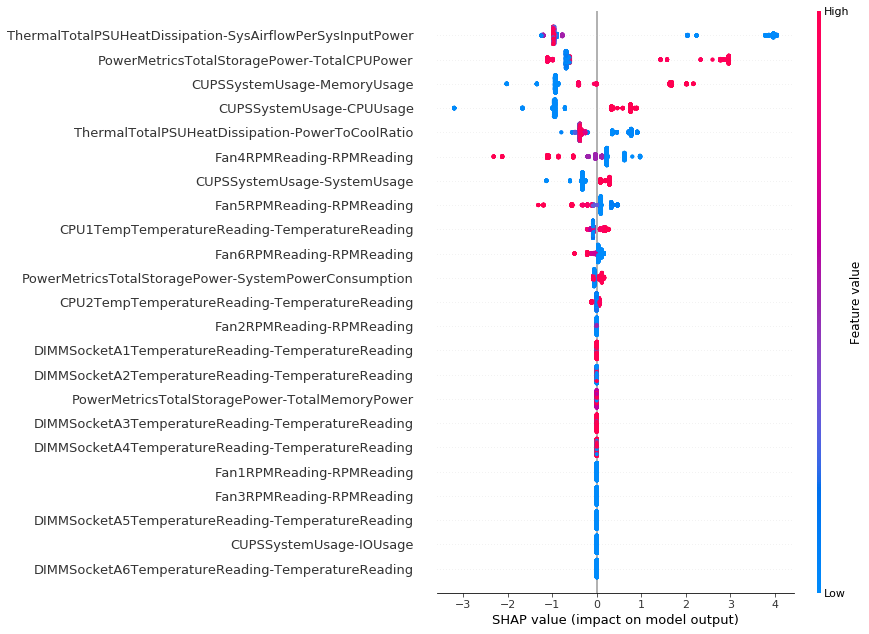



cluster 7


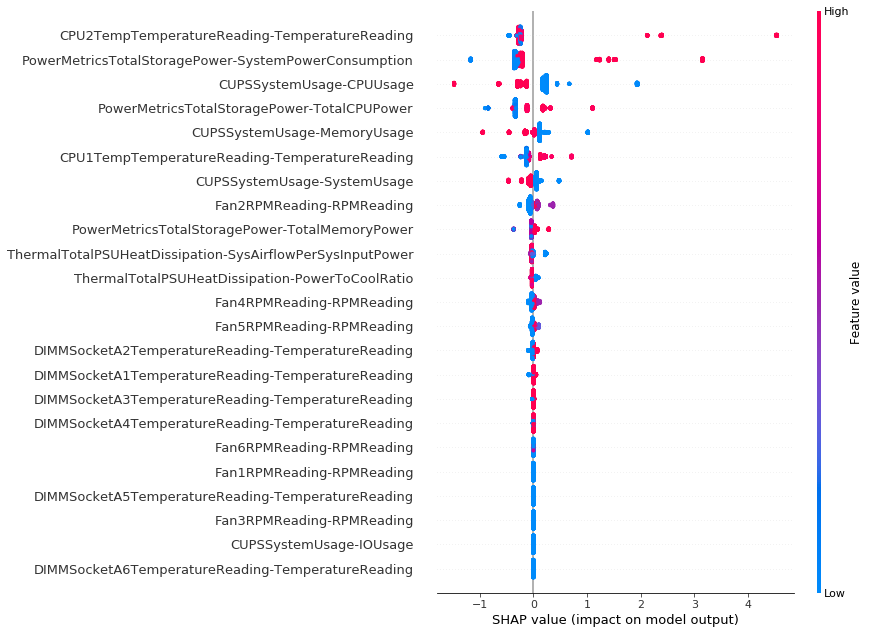



cluster 8


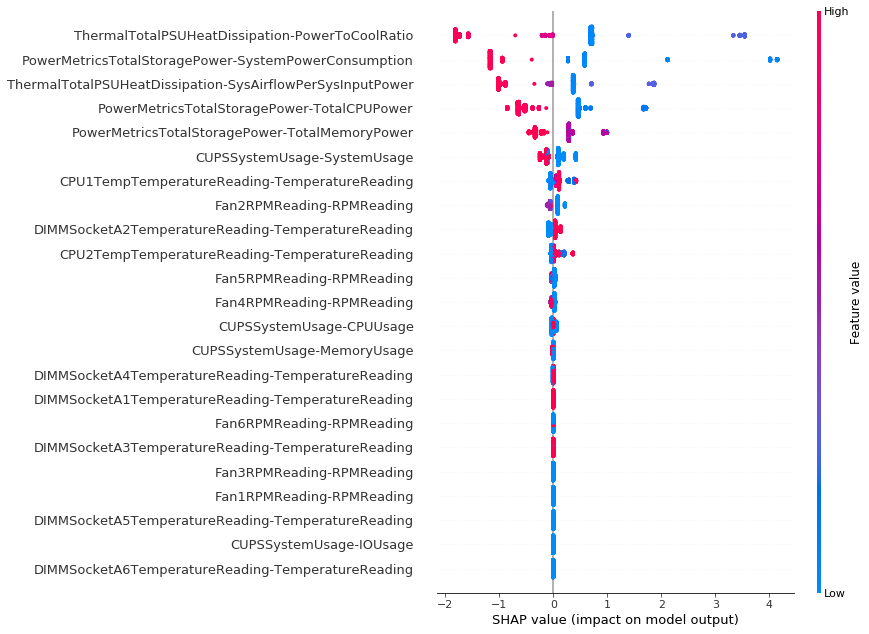

In [24]:
## Show feature importance for each instance/observation by class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display = len(feature_cols), show=False, plot_type = "dot")
    print("cluster", i)
    plt.show(f)
    print("\n")